In [95]:
import numpy as np
import gp_optimise
import matplotlib.pyplot as plt
import importlib
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
importlib.reload(gp_optimise)

<module 'gp_optimise' from '/home/cda523/Documents/Positrons/gp_optimise/gp_optimise.py'>

In [96]:
rng = np.random.default_rng()
fun0 = lambda x : np.exp(-(x)**2)
fun = lambda x : np.exp(-(x)**2) + 0.1*rng.standard_normal(len(x))*np.exp((x)**2)
dims = [{'name':'x','type':'uniform','min':-2,'max':2}]

In [121]:
def fun2(x):
    err = 0.2*x*rng.standard_normal(len(x))
    y = np.exp(-(x)**2) + np.mean(err)
    yerr = np.std(err)
    return y,yerr

In [135]:
kernel = 1*RBF(length_scale_bounds=(3e-1, 1e1))# + WhiteKernel(noise_level_bounds=(1e-2, 1e2))
gpo = gp_optimise.Gp_optimise(fun2,dims,kernel)

In [136]:
gpo.initialise(20)

/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


316**2 * RBF(length_scale=0.3)

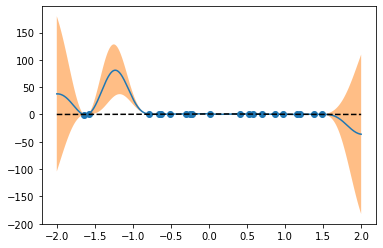

In [137]:
X_test = np.linspace(start=-2, stop=2, num=1000).reshape(-1, 1)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.scatter(gpo.X,gpo.y)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
plt.plot(X_test,fun0(X_test),'k--')
gpo.gaussian_process.kernel_

/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:372: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


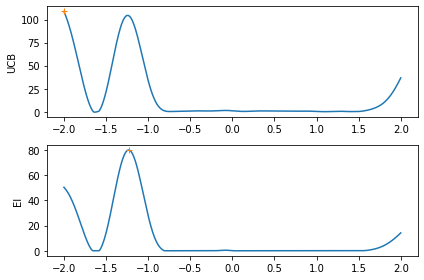

In [138]:
acq_test1 = gpo.acquisition_function(X_test,explore=1,acq_fn='UCB')
acq_test2 = gpo.acquisition_function(X_test,explore=0.01,acq_fn='EI')

nxt1 = gpo.next_acquisition(Nacq=10,explore=1,acq_fn='UCB')
nxt2 = gpo.next_acquisition(Nacq=10,explore=0.01,acq_fn='EI')

plt.subplot(2,1,1)
plt.plot(X_test,acq_test1)
plt.plot(nxt1,gpo.acquisition_function(nxt1,explore=1,acq_fn='UCB'),'+')
plt.ylabel('UCB')
plt.subplot(2,1,2)
plt.plot(X_test,acq_test2)
plt.plot(nxt2,gpo.acquisition_function(nxt2,explore=0.01,acq_fn='EI'),'+')
plt.ylabel('EI')
plt.tight_layout()


In [141]:
N_new = 5
gpo.optimise(N_new,Nacq=10,explore=1,acq_fn='UCB')

ValueError: shapes (1,23) and (22,) not aligned: 23 (dim 1) != 22 (dim 0)

ValueError: shapes (1000,23) and (22,) not aligned: 23 (dim 1) != 22 (dim 0)

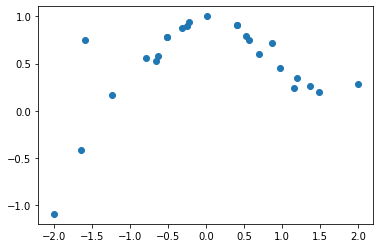

In [140]:
plt.scatter(gpo.X,gpo.y)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
plt.scatter(gpo.X[-N_new:,0],gpo.y[-N_new:])
plt.plot(X_test,fun0(X_test),'k--')
gpo.next_acquisition(Nacq=10,explore=10,acq_fn='UCB')